author: @SteveEckel

Thus script tests the various functionalities of the full hyperfine hamiltonians
contained in the pylcp package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
from pylcp import hamiltonians
from pylcp.atom import atom
from pylcp.common import cart2spherical

### Set up some basics to start

We'll code in the Briet-Rabi formula, which is useful for alkali atom ground states.  We'll also code in a method that diagonalizes the Hamiltonian and tries to keep track of the eigenvectors in order to keep track of states as we increase the magnetic field. 

In [2]:
atom_Li6 = atom("Li6")
atom_Li7 = atom("Li7")
atom_Rb85 = atom("Rb85")
atom_Rb87 = atom("Rb87")

#%% Build in some useful tools:
muB = cts.value("Bohr magneton in Hz/T")*1e-4

# The Breit-Rabi formula is excellent to compare against:
def breitrabi(B, gJ, gI, AHFS, J=1/2, I=3/2):
    """
    The Breit-Rabi formula, a nice analytic thing to compare to.
    """
    dHFS = (I+1/2)*AHFS

    x = (gJ-gI)*muB*B/dHFS

    [m_J, m_I] = np.meshgrid(np.arange(-J, J+0.001, 1),
                             np.arange(-I, I+0.001, 1))

    m_J = m_J.reshape(-1)
    m_I = m_I.reshape(-1)

    E = np.zeros((m_J.size, B.size))
    for ii in range(m_J.size):
        m = m_I[ii]+m_J[ii]

        if m == -(I+J):
            # Treat with care:
            E[ii, :] = -dHFS/(2.0*(2.0*I+1)) + gI*muB*m*B + dHFS/2.0*(1-x)
        else:
            sgn = np.sign(m_J[ii])
            E[ii, :] = -dHFS/(2.0*(2.0*I+1)) + gI*muB*m*B + \
             sgn*dHFS/2.0*(1+4*m*x/(2.0*I+1)+x**2)**0.5

    m = -(I-1)-J
    Es_max = -dHFS/(2.0*(2.0*I+1)) + gI*muB*m*B + \
                    -dHFS/2.0*(1+4*m*x/(2.0*I+1)+x**2)**0.5

    return E, Es_max


def diagnolize_and_sort(B, I, gI, state, method='uncoupled',
                        Bhat=np.array([0., 0., 1.]), dosort=True):
    """
    Diagonalize and sort does what you would expect.
    """
    nstates = int((2*state.J+1)*(2*I+1))
    Es = np.zeros((B.size, nstates), dtype='complex128')
    Vecs = np.zeros((B.size, nstates, nstates), dtype='complex128')

    if method == 'uncoupled':
        H0, mu_q = hamiltonians.hyperfine_uncoupled(
            state.J, I, gJ=state.gJ, gI=gI, Ahfs=state.Ahfs,
            Bhfs=state.Bhfs, muB=muB
            )
    elif method == 'coupled':
        H0, mu_q = hamiltonians.hyperfine_coupled(
            state.J, I, gJ=state.gJ, gI=gI, Ahfs=state.Ahfs,
            Bhfs=state.Bhfs, muB=muB
            )
    else:
        raise ValueError('method must be coupled or uncoupled.')

    # Make sure Bhat is normalized:
    Bhat = Bhat/np.linalg.norm(Bhat)
    Bq = cart2spherical(Bhat)

    # Determine the components of Bq based on the direction:
    for ii, Bi in enumerate(B):
        # Diagonalize the Hamiltonian:
        H = H0.astype('complex128')
        for jj, q in enumerate(np.arange(-1., 2., 1.)):
            H -= (-1.)**q*Bi*Bq[2-jj]*mu_q[jj]
        Es[ii, :], Vecs_i = np.linalg.eigh(H)

        # Now, we want to sort the values according to the low field groupings.
        # B=0 is like a diabolic point, in that it is really difficult to track
        # the eigenvectors around B=0.  So we must start at small, non-zero
        # field.
        if dosort and ((np.abs(B[0]) > 1e-10 and ii > 0) or\
                (np.abs(B[1]) > 1e-10 and ii > 1)):
            # Do through each vector:
            sortedind = np.zeros(Vecs.shape[2], dtype=int)
            for jj in range(Vecs.shape[2]):
                Vecdiff = np.array([np.sum((np.abs(Vecs_i[:, kk])**2 -
                                            np.abs(Vecs[ii-1, :, jj])**2)**2)
                                    for kk in range(Vecs.shape[2])])
                sortedind[jj] = np.argmin(Vecdiff)

            if np.unique(sortedind).size != sortedind.size:
                raise ValueError("Could not find 1 to 1 sorting for " +
                                 " iteration {0:d}".format(ii))
            Es[ii, :] = Es[ii, sortedind]
            Vecs[ii, :, :] = Vecs_i[:, sortedind]

            # Sort the first eigenvalues according to the energy of the lowest
            # field:
            if (np.abs(B[0]) > 1e-10 and ii == 1) or\
                    (np.abs(B[1]) > 1e-10 and ii == 2):
                sortedind = np.argsort(Es[ii, :])
                for kk in range(ii+1):
                    Es[kk, :] = Es[kk, sortedind]
                    # Have to do it in two steps or else a weird transpose
                    # operation occurs.
                    Vecs_i = Vecs[kk, :, :]
                    Vecs[kk, :, :] = Vecs_i[:, sortedind]
        else:
            Vecs[ii, :, :] = Vecs_i

    return Es, Vecs

### Now, test ground state of $^7$Li

And compare the Hamiltonian diagonalization against the Breit-Rabi formula

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$E/h$ (GHz)')

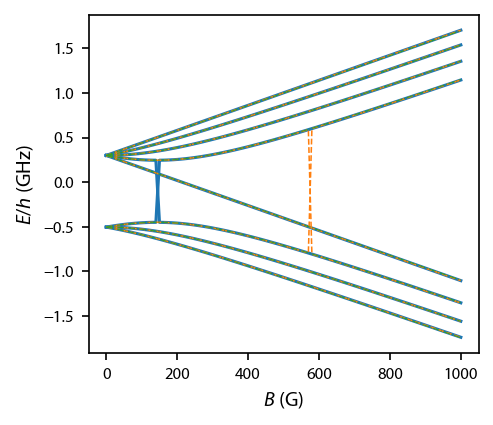

In [3]:
B = np.linspace(0.1, 1000, 101)

Es, Vecs = diagnolize_and_sort(B, atom_Li7.I, atom_Li7.gI,
                               atom_Li7.state[0], method='uncoupled')

Es_2, Vecs_2 = diagnolize_and_sort(B, atom_Li7.I, atom_Li7.gI,
                                   atom_Li7.state[0], method='coupled')

Es_3, Es_max = breitrabi(
    B, atom_Li7.state[0].gJ, atom_Li7.gI, atom_Li7.state[0].Ahfs,
    J=atom_Li7.state[0].J, I=atom_Li7.I
    )

# Plot it up:
fig, ax = plt.subplots(nrows=1, ncols=1, num="Ground State 7Li")

ax.plot(B, Es/1e9,'-', color='C0',)
ax.plot(B, Es_2/1e9,'--', color='C1', linewidth=0.75)
ax.plot(B, np.transpose(Es_3)/1e9, '-.', color='C2', linewidth=0.5)
ax.set_xlabel("$B$ (G)")
ax.set_ylabel("$E/h$ (GHz)")

### Repeat for $^6$Li:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$E/h$ (GHz)')

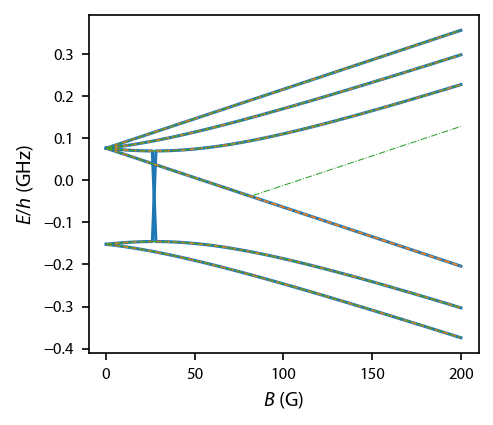

In [4]:
B = np.linspace(0.1, 200, 101)

Es, Vecs = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                               atom_Li6.state[0], method='uncoupled')

Es_2, Vecs_2 = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                                   atom_Li6.state[0], method='coupled')

Es_3, Es_max = breitrabi(
    B, atom_Li6.state[0].gJ, atom_Li6.gI, atom_Li6.state[0].Ahfs,
    J=atom_Li6.state[0].J, I=atom_Li6.I)

# Plot it up:
fig, ax = plt.subplots(nrows=1, ncols=1, num="Ground State 7Li")

ax.plot(B, Es/1e9,'-', color='C0',)
ax.plot(B, Es_2/1e9,'--', color='C1', linewidth=0.75)
ax.plot(B, np.transpose(Es_3)/1e9, '-.', color='C2', linewidth=0.5)
ax.set_xlabel("$B$ (G)")
ax.set_ylabel("$E/h$ (GHz)")

### What about the 5P$_{3/2}$ state for $^{87}$Rb:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$E/h$ (MHz)')

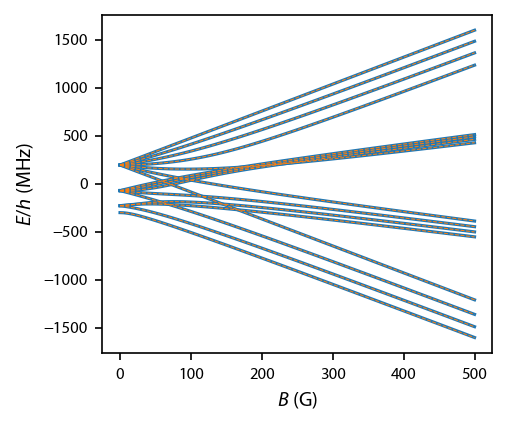

In [5]:
nstates = int((2*atom_Rb87.state[2].J+1)*(2*atom_Rb87.I+1))
B = np.linspace(0, 500, 101)

Es, Vecs = diagnolize_and_sort(B, atom_Rb87.I, atom_Rb87.gI,
                               atom_Rb87.state[2], method='uncoupled')

Es_2, Vecs_2 = diagnolize_and_sort(B, atom_Rb87.I, atom_Rb87.gI,
                                   atom_Rb87.state[2], method='coupled')

plt.figure("Rb-87 5P_{3/2} state", figsize=(3.25, 2.75))
plt.plot(B, Es/1e6, '-', color='C0')
plt.plot(B, Es_2/1e6, '--', color='C1', linewidth=0.5)
plt.xlabel("$B$ (G)")
plt.ylabel("$E/h$ (MHz)")

### Same for 2P$_{3/2}$ state for $^{7}$Li:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

(0, 19.900000000000002)

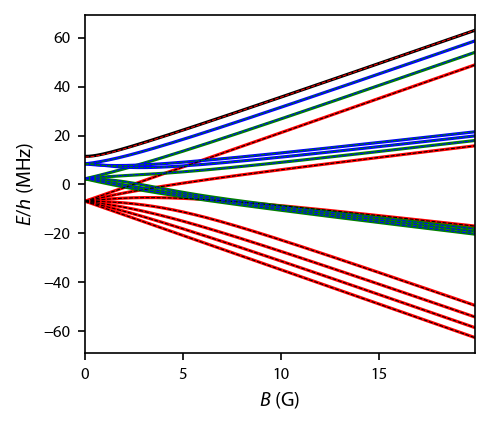

In [6]:
nstates = int((2*atom_Li7.state[2].J+1)*(2*atom_Li7.I+1))
B = np.arange(0.0, 20, 0.1)

Es, Vecs = diagnolize_and_sort(B, atom_Li7.I, atom_Li7.gI,
                               atom_Li7.state[2])
Es_2, Vecs = diagnolize_and_sort(B, atom_Li7.I, atom_Li7.gI,
                                 atom_Li7.state[2], method='coupled')

# For the ground state, manually correct after index 143:
# Es[143::,[2,4]] = Es[49::,[4,2]]
# For the 2P_{1/2} state, manually correct after index 49:
# Es[49::,[2,4]] = Es[49::,[4,2]]

plt.figure("Li-7 5P_{3/2} state", figsize=(3.25, 2.75))
plt.plot(B, Es[:, 0:7]/1e6, 'r-')
plt.plot(B, Es[:, 7:12]/1e6, 'g-')
plt.plot(B, Es[:, 12:15]/1e6, 'b-')
plt.plot(B, Es[:, 15]/1e6, 'k-')

plt.plot(B, Es_2[:, 0:7]/1e6, 'k--',linewidth=0.5)
plt.plot(B, Es_2[:, 7:12]/1e6, 'b--',linewidth=0.5)
plt.plot(B, Es_2[:, 12:15]/1e6, 'g--',linewidth=0.5)
plt.plot(B, Es_2[:, 15]/1e6, 'r--',linewidth=0.5)

plt.xlabel("$B$ (G)")
plt.ylabel("$E/h$ (MHz)")
plt.xlim((0, np.amax(B)))

### Now, 2P$_{3/2}$ state for $^{6}$Li:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(

(0, 2.975)

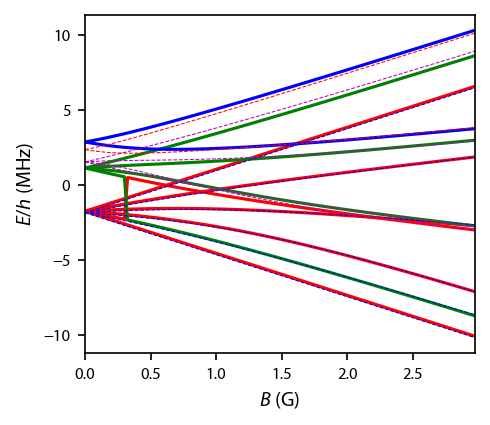

In [7]:
B = np.arange(0.0, 3, 0.025)

Es, Vecs = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                               atom_Li6.state[2])
Es_2, Vecs = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                                 atom_Li6.state[2], method='coupled')

plt.figure("Li-6 5P_{3/2} state", figsize=(3.25, 2.75))
plt.plot(B, Es[:, 0:6]/1e6, 'r-')
plt.plot(B, Es[:, 6:10]/1e6, 'g-')
plt.plot(B, Es[:, 10:12]/1e6, 'b-')

plt.plot(B, Es_2[:, 0:6]/1e6, 'b--', linewidth=0.5)
plt.plot(B, Es_2[:, 6:10]/1e6, 'm--', linewidth=0.5)
plt.plot(B, Es_2[:, 10:12]/1e6, 'r--', linewidth=0.5)

plt.xlabel("$B$ (G)")
plt.ylabel("$E/h$ (MHz)")
plt.xlim((0, np.amax(B)))

### Finally, it should not matter how the magnetic field is applied.

So let's apply it along three different directions for the ground state of $^6$Li in the coupled basis.

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 199.5)

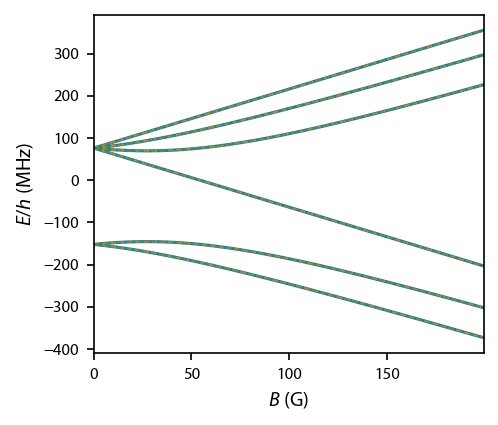

In [8]:
B = np.arange(0.0, 200, 0.5)
Bvec = np.array([np.zeros(B.size), np.zeros(B.size), np.zeros(B.size)])

Es, Vecs = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                               atom_Li6.state[0],  method='coupled')
Es_2, Vecs_2 = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                                   atom_Li6.state[0],  method='coupled',
                                   Bhat=[1,0,0], dosort=False)
Es_3, Vecs_3 = diagnolize_and_sort(B, atom_Li6.I, atom_Li6.gI,
                                   atom_Li6.state[0],  method='coupled',
                                   Bhat=[0,1,0], dosort=False)

plt.figure("Li-6 5P_{3/2} state", figsize=(3.25, 2.75))
plt.plot(B, Es/1e6, color='C0')
plt.plot(B, Es_2/1e6, '--', color='C1', linewidth=0.75)
plt.plot(B, Es_3/1e6, '-.', color='C2', linewidth=0.5)

plt.xlabel("$B$ (G)")
plt.ylabel("$E/h$ (MHz)")
plt.xlim((0, np.amax(B)))

### And it shouldn't matter what units we use

We will switch $\mu_B$ to real values and then set $\mu_B=1$.

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$B$ (G)')

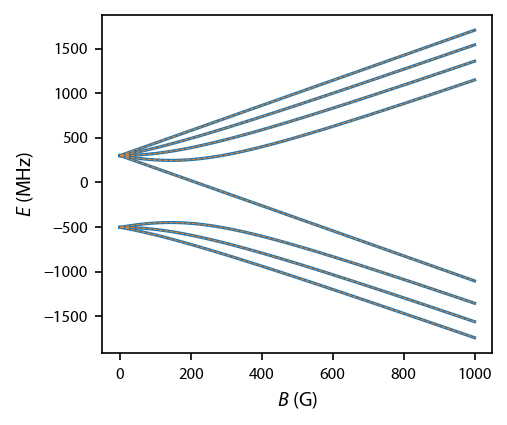

In [9]:
# Reload Li-7 atom just to start fresh
atom_Li7 = atom("Li7")

# First, real units:
muB = cts.value("Bohr magneton in Hz/T")*1e-4
B = np.linspace(0.1, 1000, 101) # G

Es, Vecs = diagnolize_and_sort(B, atom_Li7.I, atom_Li7.gI,
                               atom_Li7.state[0], method='coupled') # MHz

# Sort
Es = np.array([np.sort(Es_i) for Es_i in Es])

# Now, divide the energy scales by gamma and set muB=1, which should measure
# magnetic field in terms of Gamma, which is our energy scale.
muB = 1
atom_Li7.state[0].Ahfs = atom_Li7.state[0].Ahfs/atom_Li7.state[2].gammaHz
atom_Li7.state[0].Bhfs = atom_Li7.state[0].Bhfs/atom_Li7.state[2].gammaHz

# Conversion from magnetic field to gamma:
alpha = cts.value("Bohr magneton in Hz/T")*1e-4/atom_Li7.state[2].gammaHz

# Actually do the conversion
B2 = alpha*B

# Run the calculation:
Es_2, Vecs_2 = diagnolize_and_sort(B2, atom_Li7.I, atom_Li7.gI,
                                   atom_Li7.state[0], method='coupled') # MHz

# Sort
Es_2 = np.array([np.sort(Es_i) for Es_i in Es_2])

# Plot
fig, ax = plt.subplots(1, 1)
# Real units
ax.plot(B, Es/1e6, color='C0')
# Scaled units back to real units:
ax.plot(B2/alpha, Es_2*atom_Li7.state[2].gammaHz/1e6, '--', color='C1', linewidth=0.5)
ax.set_ylabel('$E$ (MHz)')
ax.set_xlabel('$B$ (G)')